In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [ ]:
print('Hello')

Hello


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
python src/mlm_predict.py bert-large \
        data/file_splitab \
        results/bert-base.test.core.output.jsonl

In [ ]:
mkdir saved_models


CUDA_VISIBLE_DEVICES=0 python src/finetune_mlm.py \
  --output_dir=saved_models/finetuned_roberta_large --overwrite_output_dir \
  --model_type=roberta \
  --model_name_or_path=roberta-large\
  --do_train \
  --train_data_file=data/gkb_best_num_as_subj.txt  \
  --do_eval \
  --eval_data_file=data/wiki_complete.txt \
  --per_gpu_train_batch_size 64 \
  --per_gpu_eval_batch_size 64 \
  --block_size 64 \
  --logging_steps 100 \
  --num_train_epochs 3 \
  --line_by_line --mlm 

In [ ]:
python src/mlm_infer.py \
        reload_bert:saved_models/finetuned_bert_large \
        data/test.core.masked.txt \
        results/test.core.output.jsonl

In [ ]:
python src/mlm_predict.py bert-base \
        data/file_splitab \
        results/test1.jsonl

In [ ]:
python src/mlm_predict.py\
        reload_bert:saved_models/finetuned_roberta_base\
        data/file_splitab\
        results/test_roberta_base_num_as_subj.core.output.jsonl

In [ ]:
python src/mlm_predict.py \
        reload_roberta:saved_models/finetuned_roberta_base\
        data/file_splitab\
        results/test_roberta_base_num_as_subj.core.output.jsonl

In [ ]:
python src/mlm_predict.py roberta-base \
        data/test.all.masked.txt \
        results/bert-base.test.all.output.jsonl

## FILE READER AND LOG LOSS SCORING MECHANISM

### FILE READER

In [ ]:
import json

filename = 'test_roberta_base_num_as_subj.core.output.jsonl'

In [ ]:
def read_output(filename):
    output = []
    with open(filename, 'r') as json_file:
        for line in json_file.read().splitlines():
            if not line:
                continue
            data = json.loads(line)
            truth = data['probe'].split('\t')[1]
            temp_dict = {}
            for score in data['result_list']:
                temp_dict[score['word']] = score['score']
            new_dict = {
                'scores': temp_dict,
                'truth': truth
            }
            output.append(new_dict)
    return output

In [ ]:
def count_top(output_from_read):
    correct_1 = 0
    correct_2 = 0
    correct_3 = 0
    total = 0
    for output in output_from_read:
        total += 1
        if output['truth'] in list(output['scores'].keys())[0]:
            correct_1 += 1
        if output['truth'] in list(output['scores'].keys())[:2]:
            correct_2 += 1
        if output['truth'] in list(output['scores'].keys())[:3]:
            correct_3 += 1
    print(correct_1)
    print(correct_2)
    print(correct_3)
    print(total)

In [ ]:
output = read_output(filename)

In [ ]:
count_top(output)

732
1045
1297
2088


In [ ]:
# count_top(read_output("test1.core.output_1_.jsonl"))

In [ ]:
output[0]['scores']

{'one': 0.25181469321250916,
 'seven': 0.11625459045171738,
 'three': 0.10652565211057663,
 'six': 0.1039946898818016,
 'five': 0.09896837174892426,
 'two': 0.08012425899505615,
 'eight': 0.06988321989774704,
 'four': 0.06899018585681915,
 'ten': 0.04025605320930481,
 'nine': 0.0336441732943058,
 'zero': 2.6655130568542518e-05,
 'no': 1.671322635843353e-08}

In [ ]:
output[0]['truth']

'three'

### LOG LOSS

In [ ]:
import math
L = math.log(output[0]['scores'][output[0]['truth']])

In [ ]:
L

-2.239369457947904

In [ ]:
print(len(output))

2088


In [ ]:
output_log_loss = []
for i in range(len(output)):
  curr_L = math.log(output[i]['scores'][output[i]['truth']])
  output_log_loss.append(-1 * curr_L)

In [ ]:
print(sum(output_log_loss))

4265.879620924127


In [ ]:
filename = 'test1.core.output_base.jsonl'
output = read_output(filename)

In [ ]:
output[0]['truth']

'three'

In [ ]:
output[0]['scores']

{'one': 0.1841413527727127,
 'ten': 0.12451015412807465,
 'three': 0.11748865991830826,
 'five': 0.10408899188041687,
 'two': 0.09143170714378357,
 'nine': 0.08529104292392731,
 'four': 0.08205653727054596,
 'eight': 0.07162356376647949,
 'six': 0.06290005147457123,
 'seven': 0.05609816685318947,
 'zero': 0.004227065481245518,
 'no': 1.5390251064673066e-05}

In [ ]:
count_top(output)

1040
1441
1680
2088


In [ ]:
output_log_loss_2 = []
for i in range(len(output)):
  curr_L = math.log(output[i]['scores'][output[i]['truth']])
  output_log_loss_2.append(-1 * curr_L)

In [ ]:
print(sum(output_log_loss_2))

2884.167841743178


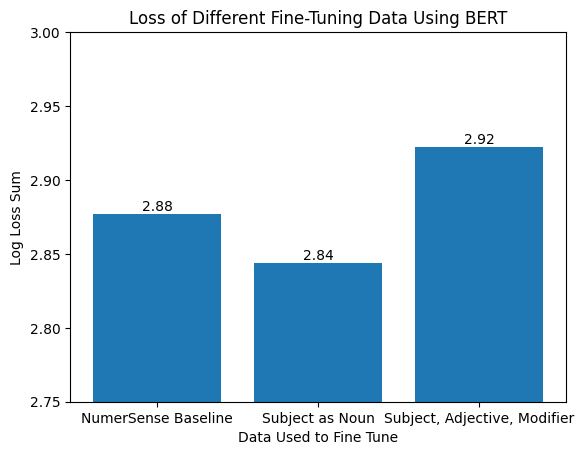

In [ ]:
import matplotlib.pyplot as plt

# Create data for the bars
x = ['NumerSense Baseline', 'Subject as Noun', 'Subject, Adjective, Modifier']
y = [2877.194 / 1000, 2844.168 / 1000, 2922.22/1000]

# Create the bar graph
plt.bar(x, y)

# Add labels to the graph
plt.xlabel('Data Used to Fine Tune')
plt.ylabel('Log Loss Sum')
plt.title('Loss of Different Fine-Tuning Data Using BERT')

for i in range(len(x)):
    plt.text(i, y[i], round(y[i], 2), ha='center', va='bottom')

plt.ylim(2.750, 3.000)
# Show the graph
plt.show()


In [ ]:
python src/mlm_predict.py bert-large \
        data/test.core.masked.txt \
        results/bert-base.test.core.output.jsonl

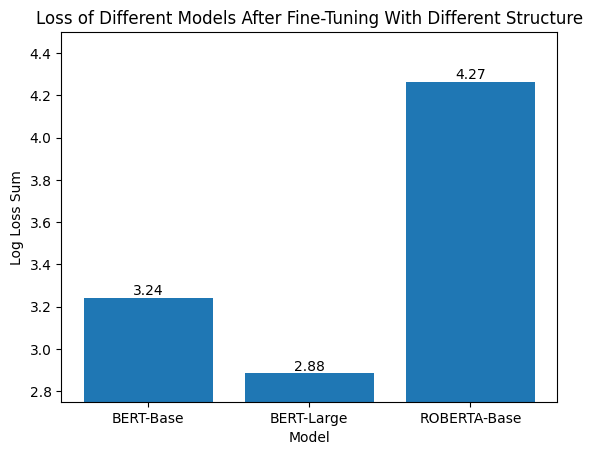

In [ ]:
# Create data for the bars
x = ['BERT-Base', 'BERT-Large', 'ROBERTA-Base']
y = [3241.616 / 1000, 2884.168 / 1000, 4265.88/1000]

# Create the bar graph
plt.bar(x, y)

# Add labels to the graph
plt.xlabel('Model')
plt.ylabel('Log Loss Sum')
plt.title('Loss of Different Models After Fine-Tuning With Different Structure')

for i in range(len(x)):
    plt.text(i, y[i], round(y[i], 2), ha='center', va='bottom')

plt.ylim(2.750, 4.500)
# Show the graph
plt.show()
